In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
data_path = './train/images/'
mask_path = './train/masks/'

images_filelist = os.listdir(data_path)
masks_filelist = os.listdir(mask_path)

image_list = []
mask_list = []

for i in images_filelist:
    img = cv2.imread(data_path + i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path + i)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    img = cv2.resize(img, (128, 128))
    mask = cv2.resize(mask, (128, 128))
    
    image_list.append(img)
    mask_list.append(mask)
    
    
image_list = np.array(image_list)
image_list = image_list.astype(float)
image_list = image_list/255

mask_list = np.array(mask_list)
mask_list = mask_list.astype(float)
mask_list = mask_list/255

print(image_list.shape, mask_list.shape)

(4000, 128, 128) (4000, 128, 128)


In [24]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from keras.models import Model


input_img = Input((128, 128, 1), name='img')
#input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
# f_repeat = RepeatVector(8*8)(input_features)
# f_conv = Reshape((8, 8, n_features))(f_repeat)
# p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 8)  584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

image_list, mask_list = shuffle(image_list, mask_list)
X_train, X_test, y_train, y_test = train_test_split(image_list, mask_list)

X_train = X_train.reshape(3000, 128, 128, 1)
y_train = y_train.reshape(3000, 128, 128, 1)

X_test = X_test.reshape(1000, 128, 128, 1)
y_test = y_test.reshape(1000, 128, 128, 1)

del image_list
del mask_list

In [25]:
hist = model.fit(X_train, y_train, validation_split = 0.1, verbose = 1, epochs = 20)

Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 37s 14ms/step - loss: 0.5799 - val_loss: 0.5309
Epoch 2/20
2700/2700 [==============================] - 37s 14ms/step - loss: 0.5422 - val_loss: 0.5257
Epoch 3/20
2700/2700 [==============================] - 37s 14ms/step - loss: 0.4632 - val_loss: 0.4437
Epoch 4/20
2700/2700 [==============================] - 36s 14ms/step - loss: 0.4045 - val_loss: 0.3822
Epoch 5/20
2700/2700 [==============================] - 36s 13ms/step - loss: 0.3527 - val_loss: 0.3376
Epoch 6/20
2700/2700 [==============================] - 36s 14ms/step - loss: 0.3225 - val_loss: 0.3414
Epoch 7/20
2700/2700 [==============================] - 36s 13ms/step - loss: 0.2999 - val_loss: 0.2786
Epoch 8/20
2700/2700 [==============================] - 36s 13ms/step - loss: 0.2819 - val_loss: 0.2637
Epoch 9/20
2700/2700 [==============================] - 36s 13ms/step - loss: 0.2644 - val_loss: 0.2548
Epoch 10/20
2700/

In [26]:
model.evaluate(X_test, y_test)

1000/1000 [==============================] - 3s 3ms/step


0.21817555046081544

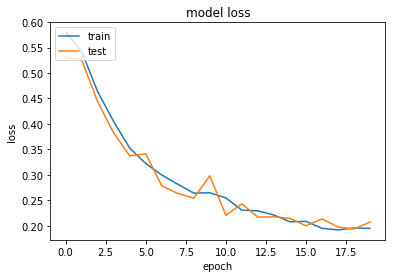

In [27]:
# # summarize history for accuracy
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model.save('basic_u_net_20.hdf5')

In [ ]:
test_data_path = './test/images/'
test_image_list = []

for i in os.listdir(test_data_path):
    img = cv2.imread(test_data_path + i)
    test_image_list.append(img)

test_image_list = np.array(test_image_list)
test_image_list = test_image_list.astype(float)
test_image_list = test_image_list/255

